# Recommendations with IBM

IBM Watson Studio platform provides articles to read to their audience, and the goal of this work is to build an article recommendation model for readers on the platform. 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Conclusion](#conclusions)


In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Showing df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Showing df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


`1.` Distribution of how many articles a user interacts with in the dataset 

In [5]:
print('The dataset contains data for {} users.'.format(df.email.nunique()))

The dataset contains data for 5148 users.


In [6]:
df_article_per_user = df.groupby('email').count()
df_article_per_user.head()

,article_id,title
email,,
0000b6387a0366322d7fbfc6434af145adf7fed1,13,13
001055fc0bb67f71e8fa17002342b256a30254cd,4,4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3,3
001a852ecbd6cc12ab77a785efa137b2646505fe,6,6
001fc95b90da5c3cb12c501d201a915e4f093290,2,2


In [7]:
df_article_per_user.article_id.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [8]:
# median and maximum number of user_article interactios
median_val = 3 # 50% of individuals interact with 3 articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is 364.

`2.` Exploring and removing duplicate articles from the **df_content** dataframe.  

In [9]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [10]:
# Removing any rows that have the same article_id - only keeping the first
df_content_new = df_content.drop_duplicates(subset=['article_id'])

`3.` Further exploration on articles, users and their interactions

In [11]:
print('Number of unique articles that have an interaction with a user: {}'.format(df.article_id.nunique()))
print('Number of unique articles in the dataset: {}'.format(df_content_new.article_id.nunique()))
print('Number of unique users in the dataset: {}'.format(df.email.nunique()))
print('Number of user - article interactions in the dataset: {}'.format(df.shape[0]))

Number of unique articles that have an interaction with a user: 714
Number of unique articles in the dataset: 1051
Number of unique users in the dataset: 5148
Number of user - article interactions in the dataset: 45993


In [12]:
unique_articles = df.article_id.nunique()# The number of unique articles that have at least one interaction
total_articles = df_content_new.article_id.nunique()# The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Finding the most viewed **article_id**, as well as how often it was viewed.

In [13]:
most_viewed_article_id = str(df.groupby('article_id').count()['title'].idxmax())# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.groupby('article_id').count()['title'].max() # The most viewed article in the dataset was viewed how many times?

In [14]:
# mapping the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [15]:
# Checking responses

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Testing the dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this dataset, we only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Let's create a function that extract the **n** top articles ordered with most interactions as the top.

In [16]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('title')\
                        .count()\
                        .iloc[:,1]\
                        .sort_values(ascending=False)\
                        .index[:n]\
                        .tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(map(str,df.groupby('article_id')\
                        .count()\
                        .iloc[:,1]\
                        .sort_values(ascending=False)\
                        .index[:n]\
                        .tolist()))
    
    return top_articles # Return the top article ids

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [19]:
# Testing
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Check responses
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Let's create a function to reformat the input dataframe **df** to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, a 1 is placed where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, a zero is placed where the user-row meets for that article-column**. 

In [20]:
# creating the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    users = df.user_id.unique()
    articles = list(map(str,df.article_id.unique()))
    user_item = pd.DataFrame(index = users, columns = articles).fillna(0)
    
    for u,a in zip(df.user_id.tolist(),list(map(str,df.article_id.tolist()))):
        user_item.loc[u,a] = 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [21]:
## Tests
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Let's create a function which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Since the results for each user here are binary, let's compute similarity as the dot product of two users. 

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_vec = user_item.loc[user_id,:]
    user_similarity = user_item.dot(user_vec)

    # sort by similarity
    user_similarity_sorted = user_similarity.sort_values(ascending=False)

    # create list of just the ids
    most_similar_users = user_similarity_sorted.index.tolist()
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [23]:
# Test
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` With the above, let's now create functions to return the articles we would recommend to user. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    #article_ids = list(map(float,article_ids))
    article_names = df[df.article_id.isin(article_ids)]['title'].unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id,:].index[user_item.loc[user_id,:] == 1].tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    seen_article_ids, seen_article_names = get_user_articles(user_id)
    similar_users = find_similar_users(user_id)
    recs = []
    
    for u in similar_users:
        # extract articles seen by similar users
        article_ids, article_names = get_user_articles(u)

        # remove articles seen by initial user
        recs += article_ids
        recs0 = recs
        del recs
        recs = [r for r in recs0 if r not in seen_article_ids]
        
        if len(recs) >= m:
            recs = recs[:m]
            break
    
    return recs # return the recommendations for this user_id    

In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['healthcare python streaming application demo',
 'ml optimization using cognitive assistant',
 'deploy your python model as a restful api',
 'visualize data with the matplotlib library',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'the unit commitment problem',
 'timeseries data analysis of iot events by using jupyter notebook',
 'the nurse assignment problem',
 'dsx: hybrid mode',
 'predicting churn with the spss random tree algorithm']

In [26]:
# Check responses
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now let's improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - let's choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, let's choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function created earlier.

In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    user_vec = user_item.loc[user_id,:]
    neighbor_id_list = find_similar_users(user_id)
    similarity = user_item.loc[neighbor_id_list,:].dot(user_vec)
    num_interactions = user_item.loc[neighbor_id_list,:].sum(axis=1)
    
    neighbors_df = pd.DataFrame(columns = ['neighbor_id','similarity','num_interactions'])
    neighbors_df['neighbor_id'] = neighbor_id_list
    neighbors_df['similarity'] = similarity
    neighbors_df['num_interactions'] = num_interactions
    
    # order users by most total interactions first (after user similarity) 
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
   
    '''
    
    neighbors_df = get_top_sorted_users(user_id)
    seen_article_ids, seen_article_names = get_user_articles(user_id)
    similar_users = neighbors_df['neighbor_id']
    recs = []
    
    for u in similar_users:
        # extract articles seen by similar users
        article_ids, article_names = get_user_articles(u)

        # remove articles seen by initial user
        recs += article_ids
        recs0 = recs
        del recs
        recs = [r for r in recs0 if r not in seen_article_ids]
        
        if len(recs) >= m:
            recs = recs[:m]
            break
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [28]:
# Checking responses
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['173.0', '349.0', '409.0', '1328.0', '1057.0', '1271.0', '906.0', '383.0', '958.0', '1430.0']

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', '10 must attend data science, ml and ai conferences in 2018', 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics', 'using github for project control in dsx', 'income (2015): united states demographic measures', 'adolescent fertility rate (births per 1,000 women ages 15-19), worldwide', 'customer demographics and sales', 'jupyter (ipython) notebooks features', 'an interview with pythonista katharine jarmul', 'using dsx notebooks to analyze github data']


`5.` Let's now test the dictionary against the solution.

In [29]:
### Tests with a dictionary of results
user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9] # Find the 10th most similar user to user 131

In [30]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

If we were given a new user, using the top most read articles as first recommendations could be the most useful. So using the function get_top_articles.  
A better way could be to allow the user to give some prefernces on topics and we could apply a knowledge based filtering for the recommendations. 

`7.` Let's provide the top 10 recommended articles for a new user below. 

In [33]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [32]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, let's use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` Let's reuse the user-item matrix and do Singular Value Decomposition.

In [43]:
# SVD on the User-Item Matrix
u, s, vt = np.linalg.svd(user_item)

`2.` In order to make predictions, we need to choose the number of latent features to use. In the cell below, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix. 

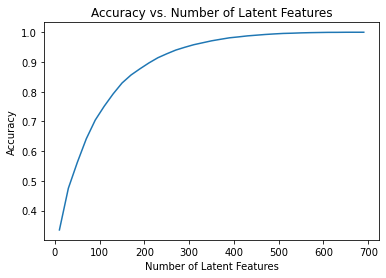

In [44]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`3.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below. 

Then let's try to understand the impact on accuracy of the training and test sets of data with different numbers of latent features by extracting the numbers below:

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [47]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [48]:
train_idx = user_item_train.index.tolist()
train_arts = user_item_train.columns.tolist()

In [49]:
print('How many users can we make predictions for in the test set?')
print(len([t for t in test_idx if t in train_idx]))

How many users can we make predictions for in the test set?
20


In [50]:
print('How many users are we not able to make predictions for because of the cold start problem?')
print(len([t for t in test_idx if t not in train_idx]))

How many users are we not able to make predictions for because of the cold start problem?
662


In [51]:
print('How many articles can we make predictions for in the test set?')
print(len([t for t in test_arts if t in train_arts]))

How many articles can we make predictions for in the test set?
574


In [52]:
print('How many articles are we not able to make predictions for because of the cold start problem?')
print(len([t for t in test_arts if t not in train_arts]))

How many articles are we not able to make predictions for because of the cold start problem?
0


In [53]:
# Testing the responses
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': 0
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now let's use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then let's find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data.

In [54]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) 

In [55]:
users_to_test = [t for t in test_idx if t in train_idx]
articles_in_test = [t for t in test_arts if t in train_arts]

In [56]:
# using boolean indexing to find the indeices for users and articles to test
s = pd.Series(user_item_train.index.isin(users_to_test))
users_to_test_idx = s[s].index

s = pd.Series(user_item_train.columns.isin(articles_in_test))
articles_in_test_idx = s[s].index

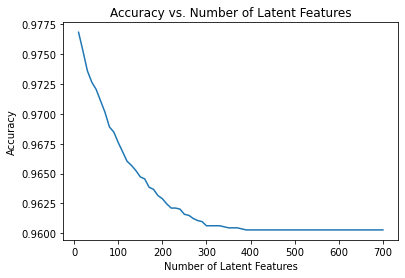

In [57]:
num_latent_feats = np.arange(10,700+10,10)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[users_to_test_idx, :k], vt_train[:k, articles_in_test_idx]
    
    # take dot product
    user_item_pred = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test.loc[users_to_test,articles_in_test], user_item_pred)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(user_item_pred.shape[0]*user_item_pred.shape[1]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` We get a slight drop in accuracy by increasing the number of latent features,but the accuracy stays more or less around the same values and actually pretty high above 96%. 
The drop could be due to the introduction of noise by increasing the size of the latent feature space which does not improve the recommendation anymore. 
Also here, the test set is only of 20 users, which is a very small sample, so it makes it difficult to have a good confidence on how much latent features are needed for a good predicted recommendation. 

In order to assess if the recommenders above are improving the way users find articles, we could preform an A/B test on two web page versions, one providing no model-based recommendations and one providing the combiations of the above recommenders.  
The null hypothesis would be: 
- providing a model-based recommendation to customers does not improve the way users find articles.   

Success metric for the test:
- Number of articles read per user visiting the site within a fixed timeframe.
